In [87]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [88]:
def simulate_hamiltonian_time_evolution(hamiltonians, times, initial_state=None):
    
    n_excited_states = len(hamiltonians[0])
    initial_hamiltonian = hamiltonians[0]
    
    if initial_state is None:
        _, eigenvectors_0 = exact_diagonalize(initial_hamiltonian)
        psi_0 = eigenvectors_0[0]
    else:
        psi_0 = initial_state

    energies = []
    time_evolved_wavefunctions = []
    state_probabilities = []
    state_overlaps = []
    true_energies = []

    psi = psi_0.copy()
    for idx, instantaneous_hamiltonian in enumerate(hamiltonians):
        
        if idx > 1:
            dt = times[idx] - times[idx - 1]
        else:
            dt = times[idx]
            
        eigenvalues, eigenvectors = exact_diagonalize(instantaneous_hamiltonian)
        true_energies.append(eigenvalues)    
        
        psi = evolve_wavefunction(psi, instantaneous_hamiltonian, dt)
        psi = psi / np.linalg.norm(psi)  
        
        time_evolved_wavefunctions.append(psi)
        
        energy = np.real(np.conj(psi).T @ instantaneous_hamiltonian @ psi)
        energies.append(energy)
        
        overlap = [np.dot(np.conj(eigenvectors[i]).T, psi) for i in range(n_excited_states)] 
        probability = [np.abs(np.conj(eigenvectors[i]).T @ psi)**2 for i in range(n_excited_states)]
               
        state_probabilities.append(probability)
        state_overlaps.append(overlap)

    energies = np.array(energies)
    time_evolved_wavefunctions = np.array(time_evolved_wavefunctions)
    state_probabilities = np.array(state_probabilities)
    state_overlaps = np.array(state_overlaps)
    true_energies = np.array(true_energies)
        
    return energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies

In [89]:

# CONSTANTS 

N = 2
M = 3
V = -1
T = 10
dt = 0.01
times = np.arange(0,T+dt,dt)

def J_V_ratio_ansatz(t, T, params):
    return params[0]*(1-t/T) +params[1]*(t/T)

def mu_V_ratio_ansatz(t, T, params):
    return params[0]*(1-t/T) +params[1]*(t/T)

# THESE SHOULD BE VARIED

J_V_ratio_params = [5,1]
mu_V_ratio_params = [10,0]

hamiltonians = []
for t in times:
    hamiltonians.append(construct_rescaled_hamiltonian(N,M,V,
                                            mu_V_ratio=mu_V_ratio_ansatz(t,T,mu_V_ratio_params),
                                            J_V_ratio=J_V_ratio_ansatz(t,T,J_V_ratio_params)))
    
results = simulate_hamiltonian_time_evolution(hamiltonians, times)
energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies = results

ground_state_fidelity = state_probabilities[-1,0]
print(ground_state_fidelity)


0.9546322870589423


In [90]:
results = simulate_hamiltonian_time_evolution(hamiltonians, times)
energies, time_evolved_wavefunctions, state_probabilities, state_overlaps, true_energies = results

ground_state_fidelity = state_probabilities[-1,0]
print(ground_state_fidelity)



0.9546322870589423


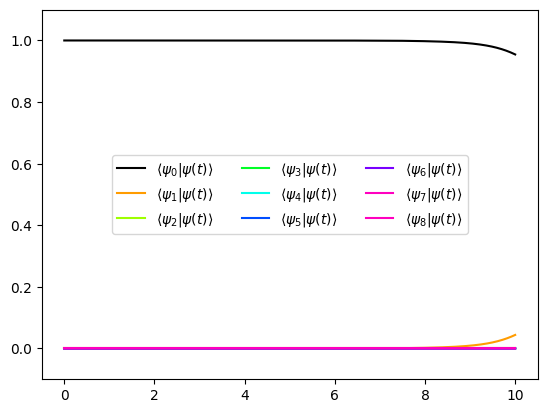

In [91]:
fig, ax = plt.subplots()
colors = get_cmap("gist_rainbow", M**N - 1)

ax.plot(times,state_probabilities[:,0], "-k", label = "$\langle \psi_0 | \psi(t) \\rangle$")
for i in range(1,M**N):
    ax.plot(times,state_probabilities[:,i], color = colors(i), label = f"$\langle \psi_{i} | \psi(t) \\rangle$")
ax.set_ylim(-0.1,1.1) 
ax.legend(ncols = 3, loc = "center")